In [21]:
# We investigate the topology of transaction types in Zcash.

from functions import *
import pandas as pd
import seaborn as sns
import statistics
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl

DPI = 600
GRANULARITY = 200000

blocks_HDD = pd.read_csv("./raw_data/HDD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])
blocks_SSD = pd.read_csv("./raw_data/SSD/eval_all_blocks.csv", names=["BLOCK", "BLOCK_NS"])

blocks_info = pd.read_csv("./data/enhanced_block.csv", names=["BLOCK", "SIZE", "VERSION", "numberTX", "numberVin", "numberVout", "numberJoinSplit", "numbervShieldedSpend", "numbervShieldedOutput"])

# Merge Data
blocks = blocks_SSD.merge(blocks_HDD, how='inner', left_on="BLOCK", right_on="BLOCK", suffixes=('_SSD', '_HDD'))
blocks = blocks.merge(blocks_info, how='inner', left_on="BLOCK", right_on="BLOCK")

if GRANULARITY:
    blocks = blocks.tail(GRANULARITY)

onlyContainingTransparent = blocks.loc[(blocks['numberJoinSplit'] == 0) & (blocks['numbervShieldedSpend'] == 0) & (blocks['numbervShieldedOutput'] == 0)]

containingJoinSplit = blocks.loc[(blocks['numberJoinSplit'] != 0)]

print('Blocks ' + blocks.iloc[0]['BLOCK'] + ' till ... ' + blocks.iloc[-1]['BLOCK'])
blocks["SIZE"] = blocks["SIZE"] / 1024 # Convert to KB

Blocks 00000000026713f4ef22ffc0096547fe88ccfe3987605e4a73c0abc617f1e926 till ... 00000000009e4f8f692d035202d57fcf3d8e62c1dd9a5802daa4f82794436b51


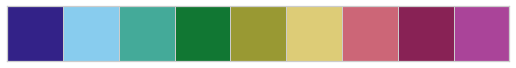

In [22]:
# Prepare plots
color = prepare_plots()

color_primary = color[0]
color_kb = color[2]
color_r2 = color_primary
color_kv = color[6]
color_gv = color[5]

name_benchmark = "Benchmark"
name_kv = "JOIST"
name_kb = "Block size"
name_gv = "Gervais $\it{et}$ $\it{al.}$"

In [23]:
# Include block height
blocks_h = blocks.copy(deep=True)
tmp = blocks_info.copy(deep=True)
tmp = tmp.reset_index()
tmp = tmp.rename(columns = {'index':'height'})
blocks_h = blocks_h.merge(tmp, how='inner', left_on="BLOCK", right_on="BLOCK")
blocks_h = blocks_h.sort_values(by=['height'])
blocks_h['height'] = blocks_h['height'] / 1000

In [24]:
blocks_h['SUM'] = blocks_h['numberVin_x'] + blocks_h['numberJoinSplit_x'] + blocks_h['numbervShieldedSpend_x'] + blocks_h['numbervShieldedOutput_x']
blocks_h['Transparent'] = blocks_h['numberVin_x']
blocks_h['Shielded'] = blocks_h['numbervShieldedSpend_x'] + blocks_h['numbervShieldedOutput_x']

blocks_h['Inputs'] = blocks_h['Transparent'] / blocks_h['SUM']
blocks_h['Spends & Outputs'] = blocks_h['Shielded'] / blocks_h['SUM']
blocks_h['JoinSplits'] = blocks_h['numberJoinSplit_x'] / blocks_h['SUM']

bock_per = pd.melt(blocks_h, id_vars=['BLOCK', 'height'], value_vars=['Inputs', 'Spends & Outputs', 'JoinSplits'], var_name='Transfer', value_name='%')

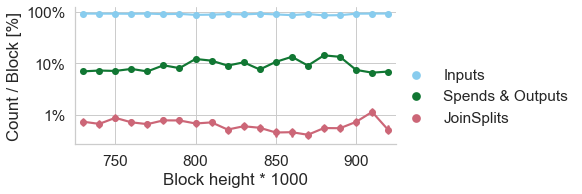

In [25]:
colors = ["#88CCEE", "#117733", "#CC6677", "#882255", "#AA4499"]
sns.set(style="whitegrid", color_codes=True, font_scale=1.4)
sns.set_palette(sns.color_palette(colors))

Q = 20
d1_bins = bock_per.copy(deep=True)
d1_bins['H_BINS'], edges = pd.qcut(d1_bins['height'], Q, retbins=True)
from matplotlib.ticker import FormatStrFormatter 
from numpy import mean
g = sns.catplot(x="H_BINS", 
                y="%",
                height=3,
                aspect=2,
                kind="point",
                estimator=mean,
                hue="Transfer",
                legend=False,
                palette=colors,
                scale=0.8,
                data=d1_bins);
                
edges = edges.astype(int)
edges = edges+14 
for ax in g.axes.flat:
    ax.set_xticklabels(edges)

ticks = ax.get_xticks()
labels = ax.get_xticklabels()

g.set(xlabel='Block height * 1000', ylabel='Count / Block [%]', yscale='log')
g.add_legend()

for ax in g.axes.flat:
    ax.set_xticks(ticks[2::5])
    ax.xaxis.grid(True)
    ax.set_xticklabels(edges[2::5])
    ax.yaxis.set_major_formatter(PercentFormatter(1))

for lh in g._legend.legendHandles: 
    lh._sizes = [50] 

g.savefig("top.pdf", bbox_inches='tight', dpi=DPI)

In [26]:
blocks_h['Inputs'].mean()

0.9003298998308918

In [27]:
blocks_h['Spends & Outputs'].mean()

0.0930646641003827

In [28]:
blocks_h['JoinSplits'].mean()

0.006605436068608475

In [29]:
containingJoinSplit.count()

BLOCK                    11337
BLOCK_NS_SSD             11337
BLOCK_NS_HDD             11337
SIZE                     11337
VERSION                  11337
numberTX                 11337
numberVin                11337
numberVout               11337
numberJoinSplit          11337
numbervShieldedSpend     11337
numbervShieldedOutput    11337
dtype: int64

In [30]:
blocks.count()

BLOCK                    200000
BLOCK_NS_SSD             200000
BLOCK_NS_HDD             200000
SIZE                     200000
VERSION                  200000
numberTX                 200000
numberVin                200000
numberVout               200000
numberJoinSplit          200000
numbervShieldedSpend     200000
numbervShieldedOutput    200000
dtype: int64